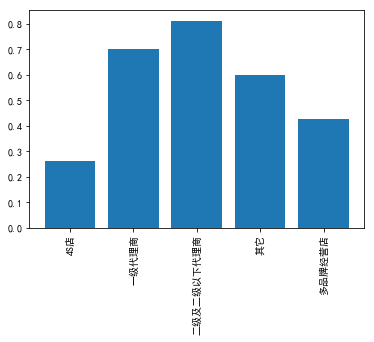

Epoch 1/100
99/99 [==============================] - 0s 4ms/step - loss: 0.6377 - acc: 0.7576
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5710 - acc: 0.7879
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5390 - acc: 0.8081
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5240 - acc: 0.8081
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5091 - acc: 0.8081
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4861 - acc: 0.8081
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4679 - acc: 0.8182
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4560 - acc: 0.8081
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4396 - acc: 0.8182
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4237 - acc: 0.8081
Epoch 11/100
99/99 [==============================] - 0s 2m

Epoch 87/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0853 - acc: 0.9596
Epoch 88/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0891 - acc: 0.9596
Epoch 89/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0830 - acc: 0.9697
Epoch 90/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0787 - acc: 0.9697
Epoch 91/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0804 - acc: 0.9697
Epoch 92/100
99/99 [==============================] - 0s 970us/step - loss: 0.0819 - acc: 0.9697
Epoch 93/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0812 - acc: 0.9697
Epoch 94/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0785 - acc: 0.9798
Epoch 95/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0827 - acc: 0.9697
Epoch 96/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0848 - acc: 0.9798
Epoch 97/100
99/99 [============================

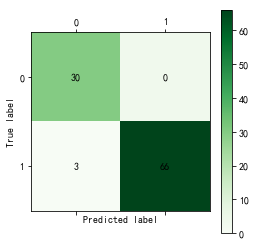

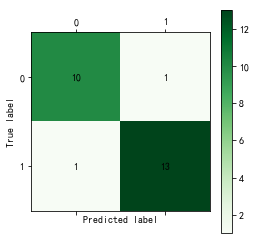

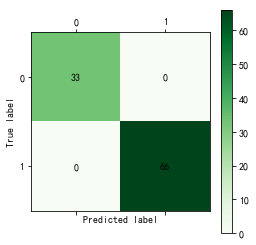

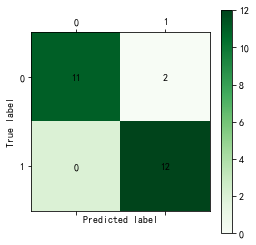

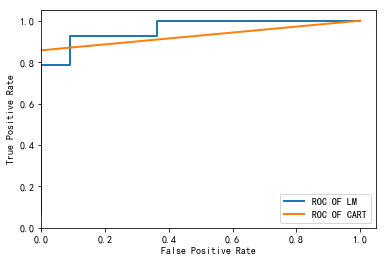

In [3]:
# -*- coding: utf-8 -*-
"""
创建时间 Thu Sep 20 10:30:31 2018
描述:
作者:PM.liugang
遗留问题:没有从专业的角度去分析，像原文中用组合后的新特征，只是进行现有特征的基础上的分析
"""
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']

def cmPlot(yTrue, yPred):
    '''
    param yTrue
    param yPred
    return
    '''
    cm = confusion_matrix(yTrue, yPred)  # 生成混淆矩阵
    plt.matshow(cm, cmap=plt.cm.Greens)  # 画混淆矩阵图，配色风格使用cm.Greens
    plt.colorbar()  # 颜色标签
    for x in range(len(cm)):  # 数据标签
        for y in range(len(cm)):
            plt.annotate(cm[x, y],
                         xy=(x, y),
                         horizontalalignment='center',
                         verticalalignment='center')
    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    return plt

ifile = 'data.xls'
data = pd.read_excel(ifile,index_col=0) # 第一列当做 行索引
t = pd.DataFrame(data.groupby([data['销售模式'],
                               data['输出']]).size()).unstack()[0] # unstack index level=1

t['异常比率'] = t['异常']/t.sum(axis=1) # 通过 unstack 获得数据异常列
t.sort_values('异常比率',ascending=False)

plt.bar(range(len(t.index)),t['异常比率'],tick_label=t.index)
plt.xticks(rotation=90)
plt.show()

data['输出'] = data['输出'].replace('正常',1) # 标签离散化
data['输出'] = data['输出'].replace('异常',0)

for m,n in enumerate(set(data['销售类型'])):
    data['销售类型'] = data['销售类型'].replace(n,m+1) # 标称类特征离散化

for m,n in enumerate(set(data['销售模式'])):
    data['销售模式'] = data['销售模式'].replace(n,m+1)

from random import shuffle
data = data.values
shuffle(data)
p=0.8
train = data[:int(len(data)*p),:]
test = data[int(len(data)*p):,:]

from keras.models import Sequential
from keras.layers.core import Dense,Activation

net = Sequential()
net.add(Dense(input_dim=14,units=10)) # 14
net.add(Activation('relu'))
net.add(Dense(input_dim=10,units=1))
net.add(Activation('sigmoid'))
net.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
hist = net.fit(train[:,:14],train[:,14],epochs=100,batch_size=1)
net.save_weights('ch06model.h5')

predict_result = net.predict_classes(train[:,:14]).reshape(len(train))
predict_result_test = net.predict_classes(test[:,:14]).reshape(len(test))

cmPlot(train[:,14],predict_result).show()
cmPlot(test[:,14],predict_result_test).show()

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(train[:,:14],train[:,14])

cmPlot(train[:,14],tree.predict(train[:,:14])).show()
cmPlot(test[:,14],tree.predict(test[:,:14])).show()

from sklearn.metrics import roc_curve
predict_result_test = net.predict(test[:,:14]).reshape(len(test)) 
# predict_result_test.shape = (25,) = (1,25)
# test[:,:14].shape = (25,14)
fpr1,tpr1,thresholds1 = roc_curve(test[:,14],
                                  predict_result_test,
                                  pos_label=1) # 标签位置
plt.plot(fpr1,tpr1,linewidth=2,label='ROC OF LM')
# CART模型
predict_result_test = tree.predict_proba(test[:, :14])[:, 1] 
# use tree.predict_proba ,not use tree.predict
# test[:, :14].reshape = (25, 14)
# test[:, 14].reshape = (1, 25)
# tree.predict_proba(test[:, :14]) .shape = (25,2)
# tree.predict_proba(test[:, :14])[:, 1].shape = (25,) = (1,25)
fpr, tpr, thresholds = roc_curve(test[:, 14], # (1,25) 
                                 predict_result_test, # (1,25)
                                 pos_label=1)
plt.plot(fpr, tpr, linewidth=2, label='ROC OF CART')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)
plt.legend(loc=4)
plt.show()